In [23]:
import openslide 
import anndata as ad
import scanpy as sc
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix
import pandas as pd
import torch
from models import model_dict
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
adata = ad.read_h5ad('40000.svs.h5ad')
adata

AnnData object with n_obs × n_vars = 19028 × 5
    obs: 'array_row', 'array_col', 'is_tissue', 'features_cluster'
    uns: 'features_cluster_colors', 'spatial'
    obsm: 'features', 'features_summary_scale1.0', 'spatial'

In [35]:
def get_model_name(model_path):
    """parse teacher name"""
    segments = model_path.split('/')[-2].split('_')
    if segments[0] != 'wrn':
        return segments[0]
    else:
        return segments[0] + '_' + segments[1] + '_' + segments[2]
def load_model(model_path, n_cls):
    print('==> loading teacher model')
    model_t = get_model_name(model_path)
    model = model_dict[model_t](num_classes=n_cls)
    
    # model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model'], strict=False)
    model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(model_path, map_location=torch.device('cuda:5'))['model'].items()}) #Because parallel was used in training
    # model = torch.load(model_path)
    print('==> done')
    return model


In [6]:
model_path = '/home/zhong/Experiment/RFD_base_crd/save/models/resnet110_ivygap_5_lr_0.05_decay_0.0005_trial_0/resnet110_best.pth'
model = load_model(model_path, n_cls=5)


==> loading teacher model
==> done


In [87]:
class adata_loader_infer(Dataset): 
    def __init__(self, adata: ad.AnnData, wsi_path: str, transform=None) -> None:
        self.adata = adata
        self.wsi = openslide.OpenSlide(wsi_path)
        wsi_name = wsi_path.split('/')[-1]
        self.center_list = adata.obsm['spatial']
        self.tile_size = int(adata.uns['spatial'][wsi_name]['scalefactors']['fiducial_diameter_fullres'])
        self.transform = transform
    
    def __len__(self):
        return self.center_list.shape[0]

    def __getitem__(self, index):
        i, j = self.center_list[index][0], self.center_list[index][1]
        tile = self.wsi.read_region((int(i - self.tile_size/2), int(j - self.tile_size/2)), 0, (self.tile_size, self.tile_size))
        tile = np.asarray(tile, dtype=np.float32)[:, :, :3]
        if self.transform is not None: 
            tile = self.transform(image=tile)["image"]
        return tile, index


In [97]:
def get_adata_dataloaders(adata, wsi_path, batch_size=128, num_workers=8): 
    transform = A.Compose(
        [
            # A.SmallestMaxSize(max_size=160),
            # A.CenterCrop(height=150, width=150),
            # A.RandomRotate90(p = 0.5),
            # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
            # A.RandomBrightnessContrast(p=1),
            # A.VerticalFlip(p=0.5),
            # A.HorizontalFlip(p=0.5),
            
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(150,150),
            ToTensorV2(),
        ]
    )
    dataset = adata_loader_infer(adata, wsi_path, transform=transform)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers)
    return dataloader


In [98]:
def inference_adata_wsi(adata, dataloader, model, device):
    model.eval()
    output_all = torch.tensor([]).to(device)
    with torch.no_grad():
        for input, _ in tqdm(dataloader):
            input = input.to(device)
            _, output = model(input)
            softmax = torch.nn.Softmax(dim=1)
            output = softmax(output)
            output_all = torch.cat((output_all, output))
    return output_all # Softmax

In [103]:

wsi_path = '/home/zhong/data/PGPD/WSI/40000.svs'
# model_path = '/home/zhong/Experiment/RFD_base_crd/save/models/resnet110_ivygap_5_lr_0.05_decay_0.0005_trial_0/resnet110_best.pth'
model_path = '/home/zhong/Experiment/RFD_base_crd/save/models/resnet110_ivygap_6_lr_0.05_decay_0.0005_trial_0/resnet110_best.pth'
model = load_model(model_path, n_cls=6)
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)
dataloader = get_adata_dataloaders(adata, wsi_path, batch_size=64, num_workers=8)
output_all = inference_adata_wsi(adata, dataloader, model, device)


==> loading teacher model
==> done
cuda:5


  0%|          | 0/298 [00:00<?, ?it/s]

100%|██████████| 298/298 [00:35<00:00,  8.50it/s]


In [104]:
output_all = np.array(output_all.cpu())
output_all

array([[1.03067067e-02, 9.31389077e-05, 1.98050886e-02, 4.65518935e-03,
        1.00905269e-01, 8.64234626e-01],
       [1.15196630e-02, 1.11175264e-04, 2.49820743e-02, 5.00385137e-03,
        1.26518935e-01, 8.31864297e-01],
       [9.70776659e-03, 8.30563877e-05, 1.79620329e-02, 3.59022315e-03,
        8.12172815e-02, 8.87439609e-01],
       ...,
       [7.74036720e-03, 1.14194372e-04, 2.91718785e-02, 4.80043050e-03,
        2.00004485e-02, 9.38172638e-01],
       [7.47654960e-03, 9.52737828e-05, 2.48967186e-02, 4.61900467e-03,
        2.66576260e-02, 9.36254799e-01],
       [7.62082729e-03, 1.07867541e-04, 2.82224864e-02, 4.96983668e-03,
        2.05857735e-02, 9.38493192e-01]], dtype=float32)

In [107]:
adata.X.data = csr_matrix(output_all)
adata.var_names = ['CTne', 'IT', 'LE', 'CT', 'CTmvp']

ValueError: unsupported data types in input

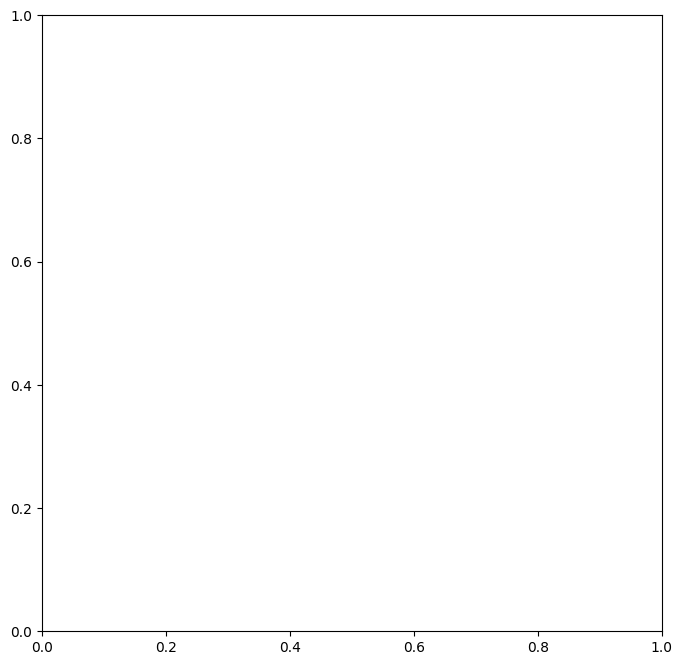

In [108]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, color=['CTne'], size=1)
sc.pl.spatial(adata, color=['IT'], size=1)
sc.pl.spatial(adata, color=['LE'], size=1)
sc.pl.spatial(adata, color=['CT'], size=1)
sc.pl.spatial(adata, color=['CTmvp'], size=1)
# sc.pl.spatial(adata, color=['BG'], size=1)

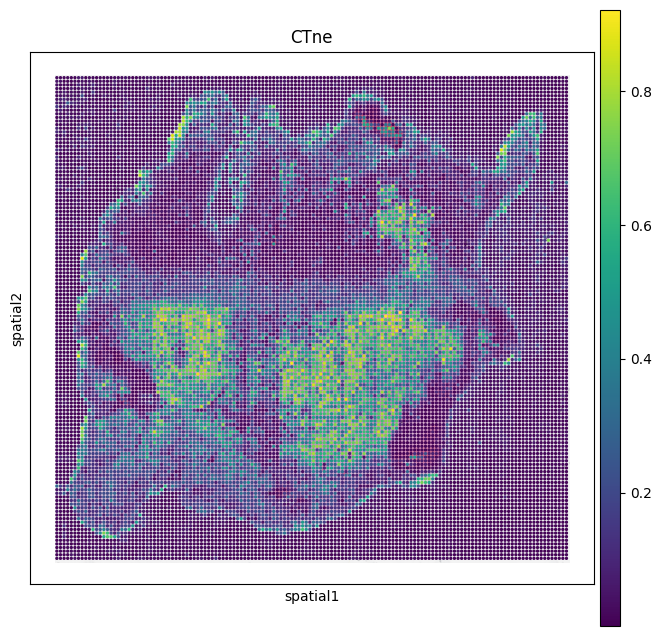

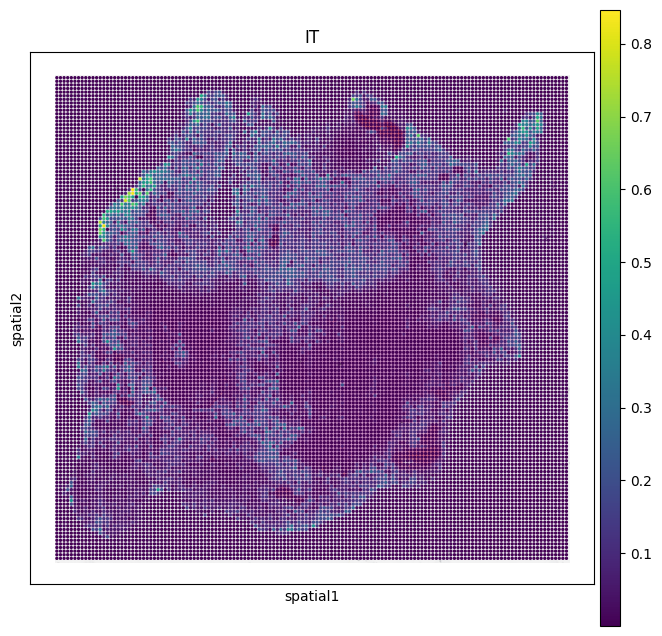

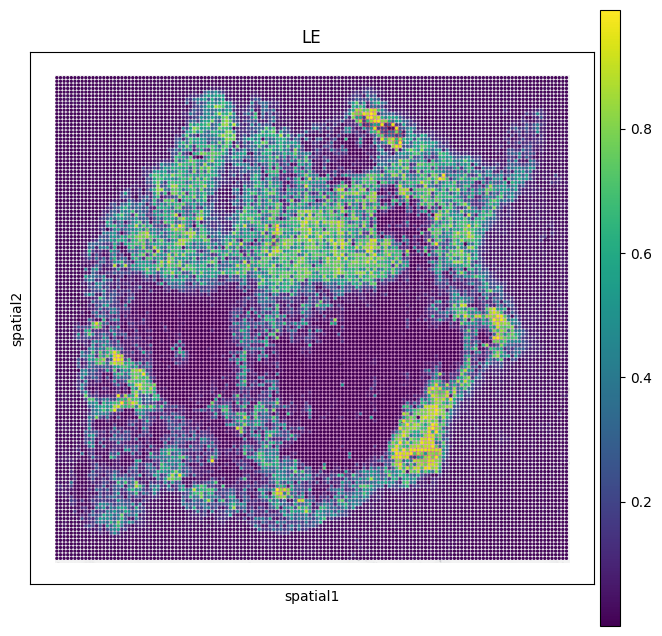

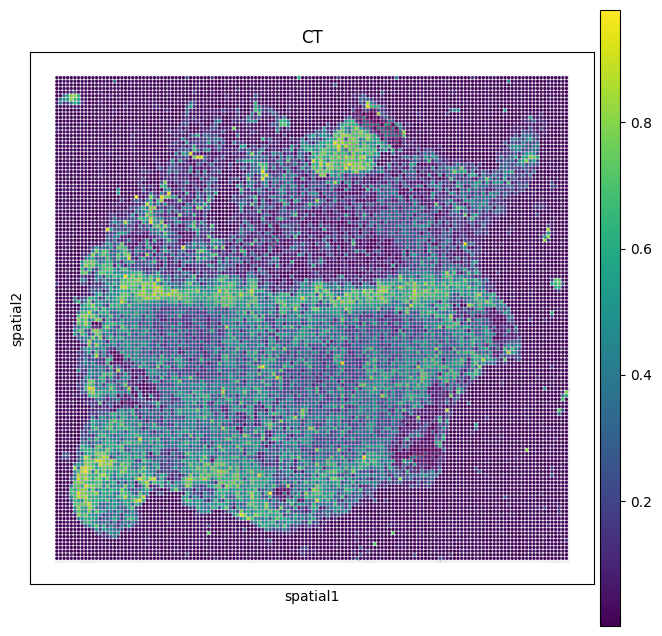

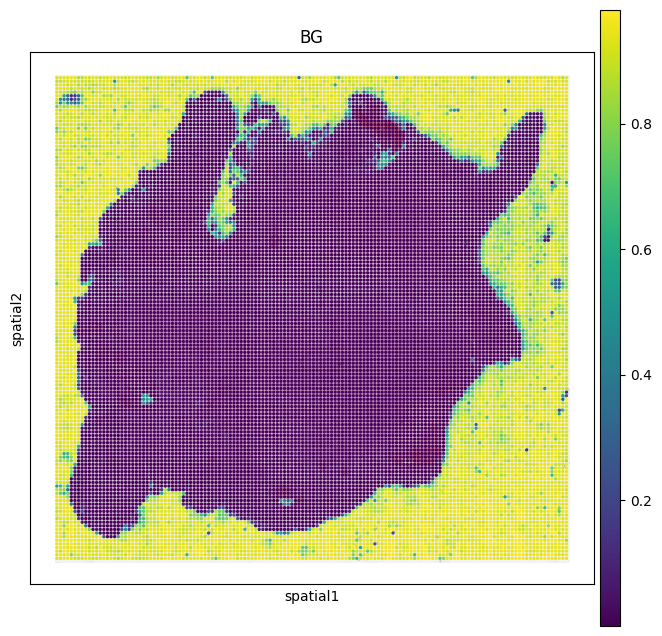

In [96]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, color=['CTne'], size=1)
sc.pl.spatial(adata, color=['IT'], size=1)
sc.pl.spatial(adata, color=['LE'], size=1)
sc.pl.spatial(adata, color=['CT'], size=1)
sc.pl.spatial(adata, color=['BG'], size=1)